# Exercise Lecture 16: Neural Generation

In this assignement, we implement an RNN model which learns to generate a film title.

A language model can predict the probability of the next word given a sequence of preceding words. Here we will create a character based language model to learn to generate a film title. 

The data is in the movies-sf.txt file on Arche. Each line of that line contains a film title followed by the year it came out (in brackets). 


In [2]:
%matplotlib inline

#### Exercise 1.1 - Creating char2int and int2char dictionaries

* Create the dictionaries mapping tokens to integers and back. Here because we train a character based model the tokens are the characters contained in the corpus. Your dictionary should include two special symbols:

- the `<eos>` symbol for padding
- the `<start>` symbol which indicates the start of the sequence (null context, this will be used as input when generating)

* Use your dictionary to convert each film titles in the corpus to sequences of integers (store this in a variable; it will be used in Exercise 2.1).

**Hint :** Cf. Exercise 1.2 in Exercise sheet 17

In [3]:
# import the data: movies + dates
with open('movies-sf.txt', 'r', encoding="utf-8") as f:
    titles = f.readlines()

In [4]:
print(titles[3])

Homunculus, 6. Teil - Das Ende des Homunculus (1917)



In [5]:
# get the set of all characters contained in the movie titles
characters_set = set()
for t in titles:
    for c in t:
        characters_set.add(c)

# also add the start and end tokens
characters = ["<start>", "<eos>"]
characters.extend(list(set(characters_set)))

print("Total number of characters:", len(characters))
print(characters)

Total number of characters: 85
['<start>', '<eos>', 'J', 'Q', '-', 'D', 'w', 'M', 'X', '2', '6', '\n', '8', 'L', '?', ' ', 'R', 'W', 'h', 'v', 'b', 'y', 'T', '.', 'f', '3', "'", '5', ')', 'C', 'a', 'K', '/', 'Y', 'z', '&', '@', 'N', ';', 'H', '_', 'E', 'm', 'i', 's', '=', 'k', 'd', '1', 'g', 'o', 'j', 'O', '(', '$', '+', '0', 'V', 'e', '7', 'p', 'x', 'r', 'I', '#', 'P', '4', '9', 't', 'c', '!', 'G', 'n', 'q', 'F', 'U', 'S', 'B', 'Z', ':', 'A', '%', 'l', 'u', ',']


In [6]:
# create the two mappings
char2int = {c:i for i,c in enumerate(characters)}
int2char = {i:c for i,c in enumerate(characters)}

In [7]:
char2int["p"]

60

In [8]:
int2char[63]

'I'

In [9]:
titles_as_char = []
for t in titles:
    # start
    seq = ["<start>"]
    # title
    for c in t:
        seq.append(c)
    #end
    seq.append("<eos>")
    titles_as_char.append(seq)

In [10]:
print(titles_as_char[3])

['<start>', 'H', 'o', 'm', 'u', 'n', 'c', 'u', 'l', 'u', 's', ',', ' ', '6', '.', ' ', 'T', 'e', 'i', 'l', ' ', '-', ' ', 'D', 'a', 's', ' ', 'E', 'n', 'd', 'e', ' ', 'd', 'e', 's', ' ', 'H', 'o', 'm', 'u', 'n', 'c', 'u', 'l', 'u', 's', ' ', '(', '1', '9', '1', '7', ')', '\n', '<eos>']


In [11]:
titles_as_ints = []
for t in titles_as_char:
    titles_as_ints.append([char2int[c] for c in t])

print(titles_as_ints[3])

[0, 39, 50, 42, 83, 72, 69, 83, 82, 83, 44, 84, 15, 10, 23, 15, 22, 58, 43, 82, 15, 4, 15, 5, 30, 44, 15, 41, 72, 47, 58, 15, 47, 58, 44, 15, 39, 50, 42, 83, 72, 69, 83, 82, 83, 44, 15, 53, 48, 67, 48, 59, 28, 11, 1]


#### Exercise 1.2 - Print out the number of titles in the data

In [12]:
print(len(titles))

7205


#### Exercise 1.3 - Print out the histogram of title lengths

We display the histogram of title lengths to decide what the maximum length will be. 

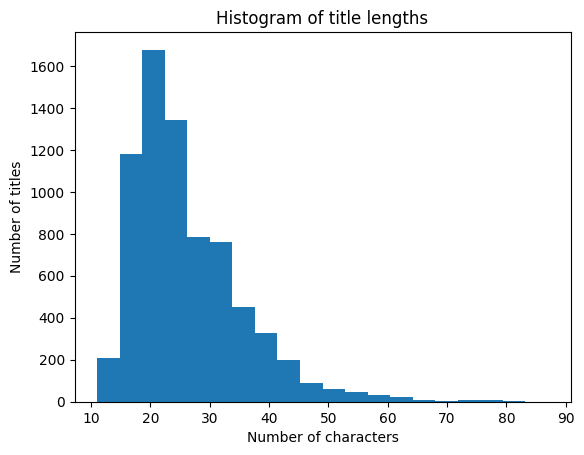

In [13]:
# plot the histogram of title lengths
import matplotlib.pyplot as plt
import numpy as np

title_lengths = [len(t) for t in titles_as_char]
plt.hist(title_lengths, bins=20)
plt.title("Histogram of title lengths")
plt.xlabel("Number of characters")
plt.ylabel("Number of titles")
plt.show()

Most titles have a length under 40 characters so we'll use 40 as maximum length when encoding the data. 

## 2. Creating the training and validation data

The RNN will iterate over the characters in x and predict the next character. Hence x is the sequence of characters over which the RNN iterates and y is the same sequence shifted by one character e.g. 

x = [1, 31, 19, 5, 9, 2, 32, ...]   
y = [31, 19, 5, 9, 2, 32, 6 ...]

where each integer corresponds to a character.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

max_len = 40
batch_size = 8
embed_size = 16
hidden_size = 64

#### Exercise  2.1 - Creating tensors

To create the X and Y tensors

* Create two long tensors X and Y of dimension (nb of training instances, max input length) and whose values are 0  (use torch.zeros())
* Iterate over the integer version of the data file you created in Exercise 1.1 and for each line l with (integer converted) title t
   - calculate the length of the title to be encoded (which is the length of the title if the title is shorter than the max len and otherwise the max len)
   - store t into a LongTensor **up to the character before last** (i.e. omit the last character)
   - set the l row of X to the long tensor version of t
* This gives you the tensor for the input, X
* To create Y do the same thing but for each title omit the first character and store the title up to and including the last character


In [26]:
X = torch.zeros(len(titles_as_ints), max_len, dtype=torch.long)
Y = torch.zeros(len(titles_as_ints), max_len, dtype=torch.long)

In [27]:
for i, title_int in enumerate(titles_as_ints):
    # if the title is longer than max_len, we keep only the first max_len characters
    length = min(len(title_int), max_len)

    # store the title up to the character just before the last one (X)
    X[i, :length-1] = torch.LongTensor(title_int[:length-1])

    # store the title from the second character to the last one (Y)
    Y[i, :length-1] = torch.LongTensor(title_int[1:length])

#### Exercise  2.2 - Checking the tensors

Check that your X and Y tensors are ok by printing the same row for both (e.g., X[30] and Y[30].

* Use the tolist() method 
* print both the integer and the character version (using the int2char dic created above)

You should see 2 lists that are almost identical: Y is X shifted by one character to the right e.g., 


X[30] = [1, 31, 19, 5, 9, 2, 32, ...]   
Y[30] = [31, 19, 5, 9, 2, 32, 6 ...]

In [28]:
print(titles_as_ints[3])
print(X[3])
print(Y[3])

[0, 39, 50, 42, 83, 72, 69, 83, 82, 83, 44, 84, 15, 10, 23, 15, 22, 58, 43, 82, 15, 4, 15, 5, 30, 44, 15, 41, 72, 47, 58, 15, 47, 58, 44, 15, 39, 50, 42, 83, 72, 69, 83, 82, 83, 44, 15, 53, 48, 67, 48, 59, 28, 11, 1]
tensor([ 0, 39, 50, 42, 83, 72, 69, 83, 82, 83, 44, 84, 15, 10, 23, 15, 22, 58,
        43, 82, 15,  4, 15,  5, 30, 44, 15, 41, 72, 47, 58, 15, 47, 58, 44, 15,
        39, 50, 42,  0])
tensor([39, 50, 42, 83, 72, 69, 83, 82, 83, 44, 84, 15, 10, 23, 15, 22, 58, 43,
        82, 15,  4, 15,  5, 30, 44, 15, 41, 72, 47, 58, 15, 47, 58, 44, 15, 39,
        50, 42, 83,  0])



#### Exercise 2.2  - Split X and Y into  train and validation data

* Split X into two parts, one called X_train which consists of the first 6500 items and the other called X_valid which includes the rest of the data
* Do the same for Y

In [29]:
X_train = X[:6500]
X_valid = X[6500:len(X)]

Y_train = Y[:6500]
Y_valid = Y[6500:len(Y)]

In [30]:
print(X_train.size(), X_valid.size())

torch.Size([6500, 40]) torch.Size([705, 40])


#### Exercise  2.3 - Use torch DataLoader to split training and validation data into batches

**Hint:** This was provided in the previous lab sessions

In [31]:
from torch.utils.data import TensorDataset, DataLoader

# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 3. Defining the Neural Network

We use a GRU (Gated Recurrent Network) as a recurrent network. There are three layers -  one embedding layer which encodes the input character into a character embedding/representation, one GRU layer (which may itself have multiple layers) that operates on that character embedding and a hidden state, and a decoder (generation) layer that outputs the probability distribution.

* Pytorch [linear](https://pytorch.org/docs/stable/nn.html?highlight=linear#torch.nn.Linear)

* Pytorch [GRU](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU)

* The main difference with the sequence tagging approach is that at each recurring step, the RNN now takes an additional input (hidden) which is the hidden state produced at the preceding time step. This ensures that the prediction made depends on the character that was generated by the RNN at the previous time step (and indirectly at all previous time steps).

In [35]:
# define the model
class RNN(nn.Module):

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super().__init__()

        # define the embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # define the GRU layer
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers = num_layers, bidirectional = False, batch_first=True)

        # define the dropout layer
        self.dropout = nn.Dropout(0.3, inplace=False)

        # define the output layer
        self.decision = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        return self.decision(self.dropout(hidden))


#### Exercise 3.1 - Specify a language model

* Modify the model provided in the previous exercise sheet (Exercise 4.1) so that the previous hidden state is input to the model

#### Exercise 3.2  - Checking the model output

* Print out the dimensions of the two tensors (output, hidden) output by your model when applied to X

In [36]:
# create the model
model = RNN(len(characters), embed_size, hidden_size, num_layers = 1)
model

RNN(
  (embed): Embedding(85, 16)
  (rnn): GRU(16, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=64, out_features=85, bias=True)
)

## Evaluation and Training

####  Define a function to evaluate the performance of the model (PROVIDED)

The function compute the perplexity of the model on the data: 

$
PP(x) = P(x)^{-\frac{1}{N}} = \left[\prod_i P(x_i)\right]^{-\frac{1}{N}}
$

where $x$ is a sequence of words, $P(x)=\prod_i P(x_i)$ is the probability assigned to that sequence by the model and $N$ its lenght. This can be rewritten in the log domain as:

$
PP(x) = exp\left(-\frac{1}{N}\sum_i \log P(x_i)\right)
$

Since the loss function returns $-\frac{1}{N}\log P(x_i)$, perplexity can be computed by taking the exponential of the avg loss. Note that we do not handle the padding hence perplexity will be affected by it. 

In [38]:
import math
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = num = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores= model(x)
        loss = criterion(y_scores.view(y.size(0) * y.size(1), -1), y.view(y.size(0) * y.size(1)))
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, math.exp(total_loss / num)

perf(model, valid_loader)

RuntimeError: shape '[320, -1]' is invalid for input of size 680

#### Exercise 3.3 - Training 

**Hint:**  Training is the same as for sequence tagging (Section 4 of Exercise Sheet 17)  modulo the added argument returned by the model.
* Define the training loop
* call you training function to iterate 5 times (epochs) over the data

In [ ]:
# YOUR CODE HERE

## 4. Generating a title (PROVIDED)

Write a function which takes the model as input and generates a title.
  
Reminder: at each time step t, the input to the model is the previous character $c_{t-1}$ and the previous hidden state $h_{t-1}$. So to initialise generation, you need to input  model with a the tensor for that letter and an initial hidden state of size hidden_size. 

* The inital hidden state should be a tensor of size  (num_layers * num_directions, batch size, hidden_size)
 with 1 the batch size (only one input in that batch)
* The initial character tensor should be of size (1,1) (one row, one char) and contain the integer for the < start > symbol. 

To generate
* use these two tensors as input to the model
* Use torch max used to compute predictions (see previous exercise sheet)
* break if the selected char (the prediction) is < eos >
* else print out the corresponding character

In [ ]:
def generate_most_probable(model):
    # size for hidden: (batch, num_layers * num_directions, hidden_size)
    hidden = torch.zeros(2, 1, hidden_size)
    print(hidden.size())
    x = torch.zeros(1, 1).long()
    x[0, 0] = char2int['<start>']
    
    for i in range(100):
      with torch.no_grad():
        y_scores, hidden = model(x, hidden)
        y_pred = torch.max(y_scores, 2)[1]
        selected = y_pred.data[0, 0]
        if selected == char2int['<eos>']:
            break
        print(int2char[selected.item()], end='')
        x[0, 0] = selected
    print()

generate_most_probable(model)